# System Curve Demo

Demonstration of developing a system curve using a Python notebook.

The example system consists of the following features and parameters:

1. DN200 SCH40 pipework with a duty flow of 70 L/s
2. Three 90° long radius elbows, two gate valves and a non-return valve
3. Total pipe length of 100 m

Comments are included in this sheet to explain what is going on and there are a number of print statements to give visibility of what information we have found from the various functions.

Reference for fluids library:

https://fluids.readthedocs.io/tutorial.html#pressure-drop-through-piping  
https://fluids.readthedocs.io/fluids.fittings.html

Install fluids library with:

```conda install -c conda-forge fluids```

In [2]:
from fluids import *
from math import pi
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define the flowrate and pipe length
Q = 70 / 1000 # m³/s
L = 100 # m

# Find the material roughness (epsilon) values
material_1 = nearest_material_roughness('steel', clean=True)
material_2 = nearest_material_roughness('steel', clean=False)
eps_1 = material_roughness(material_1) # Can also input manual values here (e.g. from AS 2200)
eps_2 = material_roughness(material_2)
print(f"Found epsilon values of {eps_1:.2e} m and {eps_2:.2e} m for new and old pipes respectively")

# Find the internal diameter of our DN200 (8" NPS) pipe
D1 = nearest_pipe(NPS=8, schedule='40')[1] # m
print(f"Pipe ID is {D1:.3f} m")

Found epsilon values of 1.52e-06 m and 1.00e-04 m for new and old pipes respectively
Pipe ID is 0.203 m


In [4]:
# Find reynolds number and friction factor
A1 = pi * D1**2 / 4 # m²
V1 = Q / A1 # m/s
Re = Reynolds(V=V1, D=D1, rho=1000, mu=1E-3)
fd_1 = friction_factor(Re, eD=eps_1/D1)
fd_2 = friction_factor(Re, eD=eps_2/D1)
print(f"Calculated friction factors for new and old pipe of {fd_1:.4f} and {fd_2:.4f} respectively")

Calculated friction factors for new and old pipe of 0.0136 and 0.0177 respectively


In [5]:
# Example K value for long radius (r = 1.5D) bend using Rennels method:
fittings.bend_rounded(D1, 90, fd_1, 1.5*D1)

0.18733750222729295

In [6]:
# Example K value for gate valve
fittings.K_gate_valve_Crane(D1, D1, 0, fd_1)

0.10856505278444441

In [7]:
# For the non-return valve say we have a Valmatic Surgebuster which at NPS 8 has a Cv of 1900
Cv_to_K(1900, D1)

1.000831053390248

In [8]:
# Sum up K values for new pipe:
K1 = 3 * fittings.bend_rounded(D1, 90, fd_1, 1.5*D1)
K1 += 2 * fittings.K_gate_valve_Crane(D1, D1, 0, fd_1)
K1 += Cv_to_K(1900, D1) # non-return valve with Cv of 1900

# Sum up K values for old pipe:
K2 = 3 * fittings.bend_rounded(D1, 90, fd_2, 1.5*D1)*3
K2 += 2 * fittings.K_gate_valve_Crane(D1, D1, 0, fd_2)
K2 += Cv_to_K(1900, D1) # non-return valve with Cv of 1900

print(f"Calculated total K values for new and old pipe of {K1:.2f} and {K2:.2f} respectively")

Calculated total K values for new and old pipe of 1.78 and 3.29 respectively


In [9]:
# Add in the equivalent K value from friction
K1 += K_from_f(fd_1, L, D1)
K2 += K_from_f(fd_2, L, D1)

In [10]:
# Calculate high and low headloss values at our duty point:
H1 = head_from_K(K1, V1)
H2 = head_from_K(K2, V1)

print(f"Calculated headloss for new and old pipe of {H1:.2f} m and {H2:.2f} m respectively")

Calculated headloss for new and old pipe of 2.03 m and 2.89 m respectively


## System Curve Plotting

Now that we have defined the full system K value we can plot the system curves for both the new/clean state and aged state of the pipework. This creates a range of system curves which will be plotted here as an area.

In [11]:
# Create an array of flowrates for plotting
Q_ = np.arange(0, Q, step= 5 / 1000) # m³/s
V_ = Q_ / A1 # convert flowrate array to velocity array

# Calculate headloss values for the full range
H1_ = head_from_K(K1, V_)
H2_ = head_from_K(K2, V_)

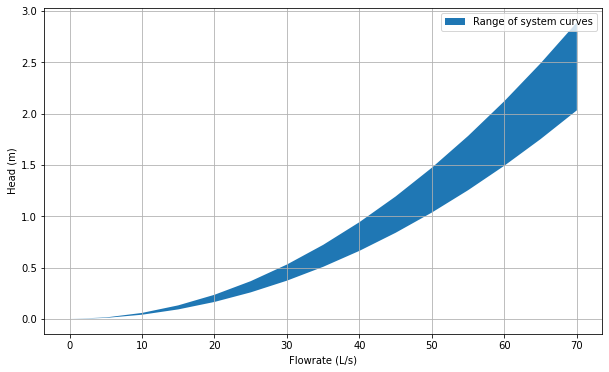

In [12]:
# Create plot
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.fill_between(Q_*1000, H2_, H1_)
ax1.set(xlabel='Flowrate (L/s)', ylabel='Head (m)')
plt.legend(["Range of system curves"])
ax1.grid()
plt.show()

## Pump Curve Plotting

With our range of system curves calculated we can add a pump curve. For simplicity we will assume a fixed speed pump in this example. If the pump is operating on a VSD then the affinity laws can be used to find the range of operating head & flowrates.

In [13]:
# Hypothetical pump curve data at 50 Hz
Hp1 = 3.0 - 500 * Q_**2

# Slow pump down to 35 Hz
N1 = 50 # Hz
N2 = 35 # Hz

# Affinity laws for flow and head
Q2 = Q_ / (N1/N2)
Hp2 = Hp1 / (N1/N2)**2

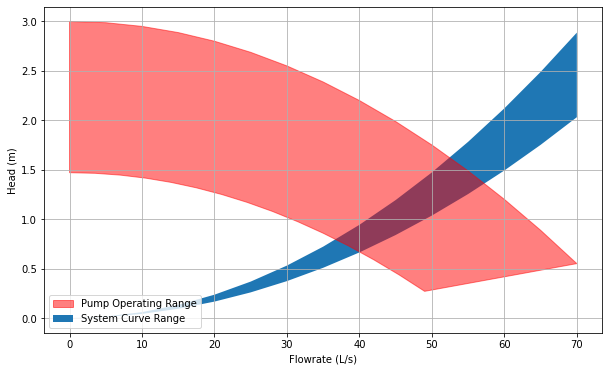

In [14]:
# Re-create the system curve plot and add in the pump curve
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.fill_between(Q_*1000, H2_, H1_, label='System Curve Range')
ax1.fill(np.concatenate((Q_*1000, Q2[::-1]*1000)), np.concatenate((Hp1, Hp2[::-1])), color='red',
    alpha=0.5, label='Pump Operating Range') # pump curve
ax1.set(xlabel='Flowrate (L/s)', ylabel='Head (m)')
plt.legend()
ax1.grid()
plt.show()

The overlap between the pump operating range and range of system curves represents the range in which the system can operate depending on VSD frequency and system condition.